**Version 1.2** (improved) : early stopping, 1 epoch, accuracy ~95%


c:\Users\newUser\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset téléchargé dans : C:\Users\newUser\.cache\kagglehub\datasets\andrewmvd\medical-mnist\versions\1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Batch 1/1474, Loss: 1.8576
Epoch 1/1, Batch 2/1474, Loss: 1.6483
Epoch 1/1, Batch 3/1474, Loss: 1.5506
Epoch 1/1, Batch 4/1474, Loss: 1.5477
Epoch 1/1, Batch 5/1474, Loss: 1.5320
Epoch 1/1, Batch 6/1474, Loss: 1.3829
Epoch 1/1, Batch 7/1474, Loss: 1.3149
Epoch 1/1, Batch 8/1474, Loss: 1.2620
Epoch 1/1, Batch 9/1474, Loss: 1.2943
Epoch 1/1, Batch 10/1474, Loss: 1.0947
Epoch 1/1, Batch 11/1474, Loss: 1.1216
Epoch 1/1, Batch 12/1474, Loss: 1.0566
Epoch 1/1, Batch 13/1474, Loss: 1.1050
Epoch 1/1, Batch 14/1474, Loss: 0.9809
Epoch 1/1, Batch 15/1474, Loss: 1.0052
Epoch 1/1, Batch 16/1474, Loss: 0.9441
Epoch 1/1, Batch 17/1474, Loss: 0.8845
Epoch 1/1, Batch 18/1474, Loss: 0.8762
Epoch 1/1, Batch 19/1474, Loss: 0.9133
Epoch 1/1, Batch 20/1474, Loss: 0.7860
Epoch 1/1, Batch 21/1474, Loss: 0.7377
Epoch 1/1, Batch 22/1474, Loss: 0.6542
Epoch 1/1, Batch 23/1474, Loss: 0.6866
Epoch 1/1, Batch 24/1474, Loss: 0.6760
Epoch 1/1, Batch 25/1474, Loss: 0.6306
Epoch 1/1, Batch 26/1474, Loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].


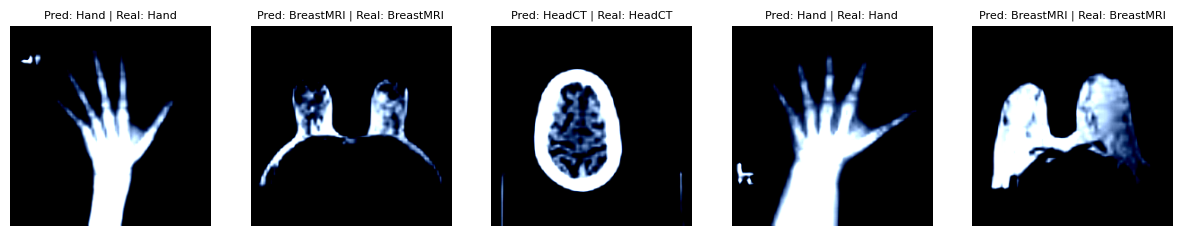

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not NoneType

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from transformers import ViTForImageClassification
from sklearn.metrics import classification_report
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
# For attention :
import torchvision.transforms.functional as F
import matplotlib.cm as cm
from PIL import Image


# dataset download
path = kagglehub.dataset_download("andrewmvd/medical-mnist")
print("Dataset téléchargé dans :", path)

def get_dataloader(path, batch_size=32, seed=42):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = datasets.ImageFolder(root=path, transform=transform)

    # random seed
    torch.manual_seed(seed)
    # train / test division
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, dataset.classes

# loading data
train_loader, val_loader, test_loader, class_names = get_dataloader(path)

# loading the ViT google model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(class_names),
    ignore_mismatched_sizes=True,
    hidden_dropout_prob=0.2,  # dropouts
    attention_probs_dropout_prob=0.2  # dropouts
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# optimizations
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)  # small lr as the images are simple
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
num_epochs = 1


# training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # early stopping
        if loss.item() < 0.2:
            print("Perte satisfaisante atteinte, arrêt de l'entraînement.")
            break

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {running_loss/len(train_loader):.4f}")

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader):.4f}")

# evaluation
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, y_true, y_pred

# Report with accuracy
test_accuracy, y_true, y_pred = evaluate(model, test_loader, device)
print(f'Accuracy on test set: {test_accuracy:.2f}%')
print(classification_report(y_true, y_pred, target_names=class_names))

# visually printing predictions and real labels
def show_some_predictions(model, dataloader, device, class_names):
    model.eval()
    images, labels = next(iter(dataloader))  # Prendre un batch
    images, labels = images.to(device), labels.to(device)
    outputs = model(images).logits  # Accéder aux logits
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0)  # Convertir en format affichable
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {class_names[predicted[i].item()]} | Real: {class_names[labels[i].item()]}', fontsize=8)
        axes[i].axis('off')
    plt.show()

show_some_predictions(model, test_loader, device, class_names)



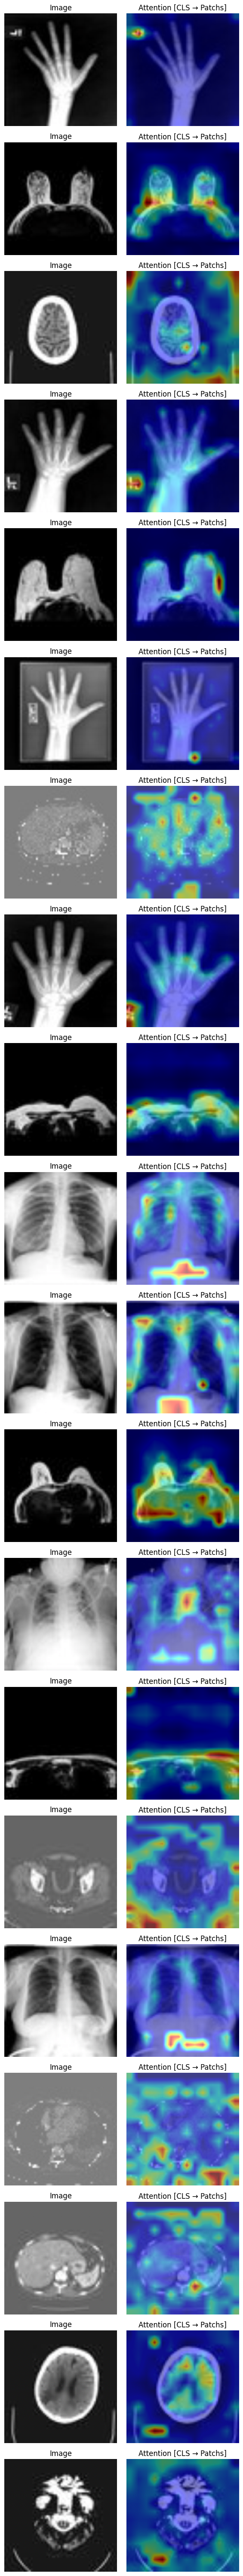

In [3]:
def visualize_attention(model, dataloader, device, num_images=20):
    import matplotlib.pyplot as plt
    import torch.nn.functional as F

    model.eval()

    # Prendre un batch d'images
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)  # on limite à `num_images`
    
    # Propagation avec sortie des attentions
    outputs = model(images, output_attentions=True)
    attentions = outputs.attentions  # List of [batch, heads, tokens, tokens]
    
    # On prend la dernière couche d'attention
    attn_last = attentions[-1]  # [batch, heads, tokens, tokens]

    # On veut l'attention de [CLS] vers tous les patchs : token[0] -> token[1:]
    # Extraire la moyenne sur les têtes
    attn_maps = attn_last.mean(dim=1)  # [batch, tokens, tokens]

    # Retirer la première ligne (CLS → patchs)
    attn_cls = attn_maps[:, 0, 1:]  # [batch, num_patches]

    num_patches = attn_cls.size(-1)
    size = int(num_patches ** 0.5)  # normalement 14x14 pour 224x224 et patch 16

    fig, axes = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))

    for i in range(num_images):
        # Image originale
        img = images[i].detach().cpu().permute(1, 2, 0)
        img = (img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])).clip(0, 1)

        # Carte d’attention du [CLS]
        attn = attn_cls[i].detach().cpu().reshape(size, size)
        attn = F.interpolate(attn.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear').squeeze()

        # Image + Attention
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Image")

        axes[i, 1].imshow(img)
        axes[i, 1].imshow(attn, cmap='jet', alpha=0.5)  # superposition
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Attention [CLS → Patchs]")

    plt.tight_layout()
    plt.show()

visualize_attention(model, test_loader, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06293353..2.622571].
Clipping i

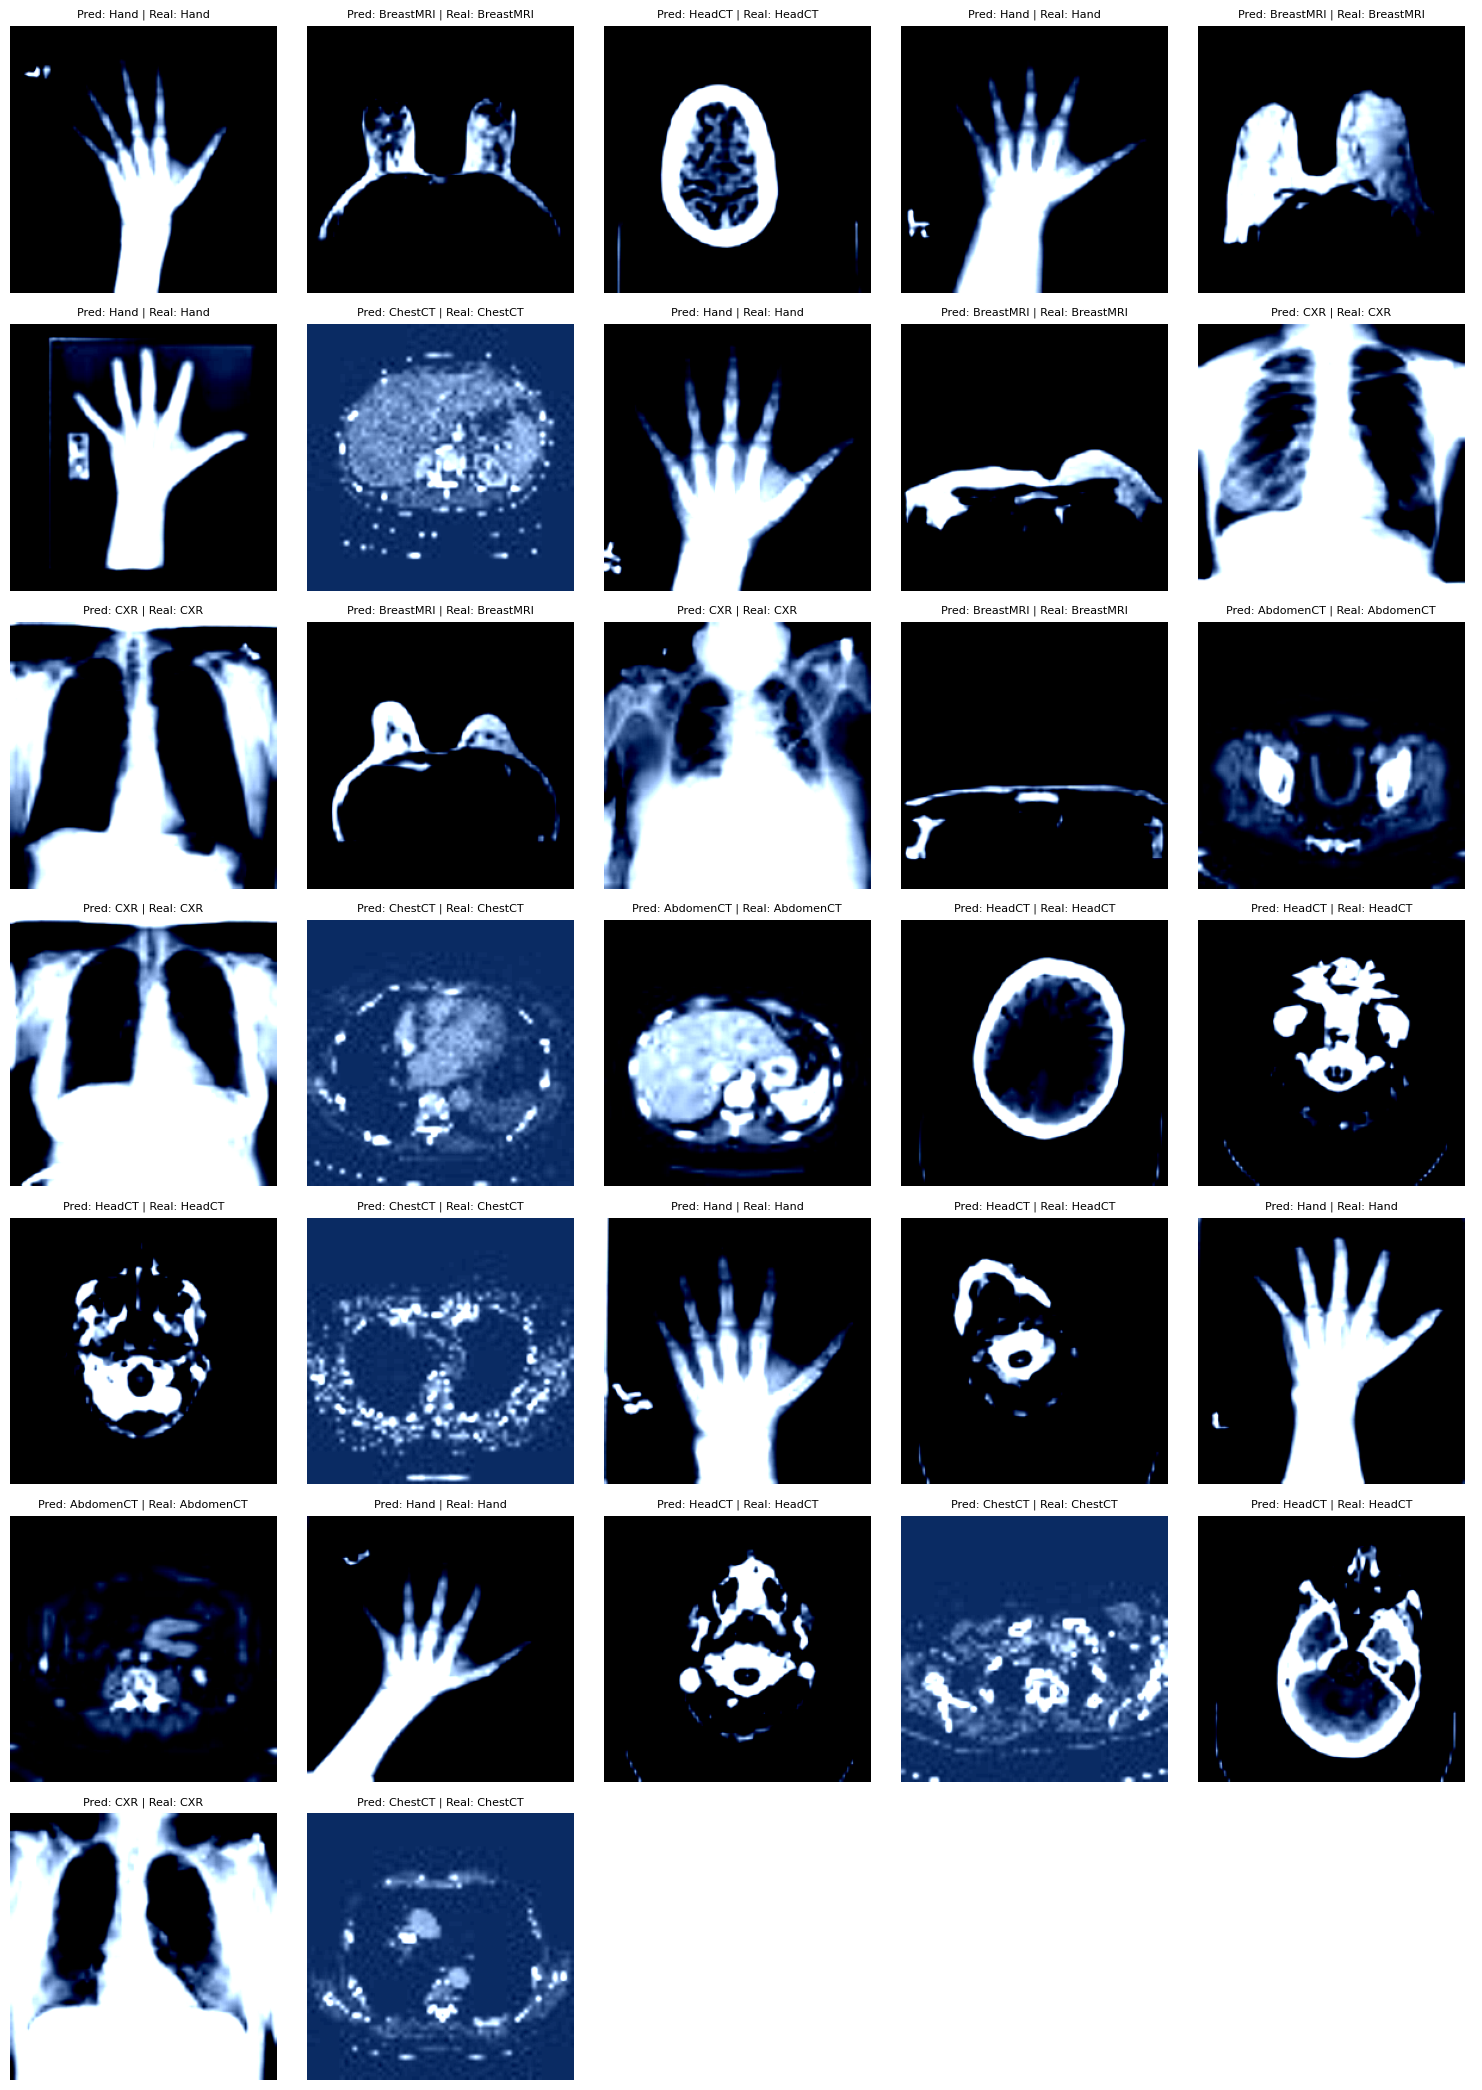

In [11]:
#show more predictions with the labels
def show_more_predictions(model, dataloader, device, class_names, num_images=32):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images).logits
    _, predicted = torch.max(outputs, 1)


    num_cols = 5
    num_rows = int(np.ceil(num_images / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols


        ax = axes[col] if num_rows == 1 else axes[row, col]

        img = images[i].cpu().permute(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[predicted[i].item()]} | Real: {class_names[labels[i].item()]}', fontsize=8)
        ax.axis('off')

    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        ax = axes[col] if num_rows == 1 else axes[row, col]
        ax.axis('off')

    plt.tight_layout()  # adjust spacing between subplots
    plt.show()

# 32 predictions (1 batch)
show_more_predictions(model, test_loader, device, class_names, num_images=32)